<h1 style="font-size:35px;
        color:black;
        ">Lab 6 Grover’s search with an unknown number of solutions</h1>

Prerequisite
- [Ch.3.10 Grover's Algorithm](https://qiskit.org/textbook/ch-algorithms/grover.html)
- [Ch.3.11 Quantum Counting](https://qiskit.org/textbook/ch-algorithms/quantum-counting.html)

Other relevant materials
- [Section 3.3 Measuring T1 in Ch.6.1](https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-pulse.html#3.3-Measuring-$T_1$-using-Inversion-Recovery-)
- [QCQI] Michael A. Nielsen and Isaac L. Chuang. 2011. Quantum Computation and Quantum Information

In [105]:
from qiskit import *
from qiskit.tools.visualization import plot_histogram
from qiskit.quantum_info import Operator, Statevector
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.mitigation.measurement import *

import numpy as np
import matplotlib.pyplot as plt

## *Before we start: some Qiskit tips*

If we have a circuit

In [2]:
qc_x = QuantumCircuit(1)
qc_x.x(0)
qc_x.name = 'x'

we can turn it into a gate

In [3]:
x_gate = qc_x.to_gate()

and then use it in other circuits.

In [4]:
qc = QuantumCircuit(2)

qc.append(x_gate, [0])

qc.draw()

┌───┐
q_0: ┤ x ├
     └───┘
q_1: ─────

We can also create a controlled version

In [5]:
cx_gate = x_gate.control()

and similarly add that to circuits.

In [6]:
qc.append(cx_gate, [0,1])

qc.draw()

┌───┐     
q_0: ┤ x ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ x ├
          └───┘

These ideas come in very handy for phase estimation.

<h2 style="font-size:24px;">Part 1: Quantum Counting</h2>

<br>
<div style="background: #E8E7EB; border-radius: 5px;
-moz-border-radius: 5px;">
  <p style="background: #800080;
            border-radius: 5px 5px 0px 0px;
            padding: 10px 0px 10px 10px;
            font-size:18px;
            color:white;
            "><b>Goal</b></p>
    <p style=" padding: 0px 0px 10px 10px;
              font-size:16px;">Construct a circuit for quantum counting implementing the IPE (Iterative Phase Estimation) algorithm to find the number of solutions to a search problem.</p>
</div>


In [Ch.3.10 Grover's Algorithm](https://qiskit.org/textbook/ch-algorithms/grover.html), we learned how to find search problem solutions through Grover's algorithm and the number of solutions utilizing the quantum counting circuit in [Ch.3.11 Quantum Counting](https://qiskit.org/textbook/ch-algorithms/quantum-counting.html).  The number of solutions toghther with the numbe of total items in the search space determine how many Grover iterations, the number of oracle calls, is required. In the part 1 of this lab, we build the quantum counting circuit implementing IPE ( Iterative Phase Estimation ) algorithm rather than the way the circuit was created in [Ch.3.11 Quantum Counting](https://qiskit.org/textbook/ch-algorithms/quantum-counting.html) with Quantum Phase Estimation (QPE).

<h3 style="font-size: 20px">1. Find the number of solutions of the given oracle for a search problem through quantum counting. 

<h4 style="font-size: 17px">Step A. Construct a gate for Grover iteration. </h4>

Consider the search space with the total numbe of item, $N = 8$. Run the following circuit to construct an oracle of a search problem.

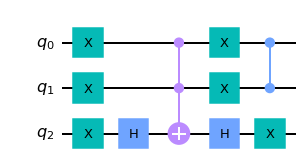

In [164]:
## Create an Oracle

N = 8 # the number of total items in the search space
m = int(np.log2(N)) # the number of qubits required to construct the search space with N items

myqc = QuantumCircuit(m, name='Oracle')

num_solutions = 3

if num_solutions==4:

    # solutions are 010 and 001, 110 and 101
    
    myqc.x(1)
    myqc.z(range(2)) # this alone corresponds to solutions 000 and 011, 100 and 111
    myqc.x(1)
    
if num_solutions in [1,3]:

    # solution is 000
    
    myqc.x(range(m))
    
    # this alone corresponds to solution 111
    myqc.h(m-1) # hadamards used to rotate mcx to mcz
    myqc.mcx(list(range(m-1)),m-1)
    myqc.h(m-1)
    
    myqc.x(range(m))

if num_solutions in [2,3]:

    # solutions are 011 and 111
    
    myqc.cz(0,1)
    
Oracle = myqc.to_gate()

myqc.draw(output='mpl')

We can see these marked solutions in the statevector.

In [165]:
from qiskit.quantum_info import Statevector

hads = QuantumCircuit(m)
hads.h(range(m))
ket = Statevector(hads.compose(myqc))
ket.to_dict()

{'000': (-0.3535533905932736+0j),
 '001': (0.3535533905932736+0j),
 '010': (0.3535533905932736+0j),
 '011': (-0.3535533905932736+0j),
 '100': (0.3535533905932736+0j),
 '101': (0.3535533905932736+0j),
 '110': (0.3535533905932736+0j),
 '111': (-0.3535533905932736+0j)}

&#128211; Complete the circuit, `qc`, to create Grover iteration gate/operator, `Grover`, by adding the diffuser, explained as the step 3 in the first section `1.Introdcution` of [Ch.3.10 Grover's Algorithm](https://qiskit.org/textbook/ch-algorithms/grover.html).

In [166]:
qc = QuantumCircuit(m)
qc.append(Oracle, range(m))

### solution here
myqc = QuantumCircuit(m, name='Diffuser')

# transform |+> to |1>
for j in range(m):
    myqc.z(j)
    myqc.h(j)

# apply multiply controlled-Z, which gives a phase to the all |1> state
myqc.h(m-1)
myqc.mcx(list(range(m-1)),m-1)
myqc.h(m-1)
  
# transform |1> to |+>
for j in range(m):
    myqc.h(j)
    myqc.z(j)
    
# get global phase of -1 (there must be a better way!)
myqc.z(0)
myqc.x(0)
myqc.z(0)
myqc.x(0)

Diffuser = myqc.to_gate()
qc.append(Diffuser, range(m))
####

Grover = qc.to_gate()

<h4 style="font-size: 17px">&#128211;Step B. Build a quantum circuit, 'circ', for quantum counting employing the IPE algorithm to find the eigenvalue of the Grover iterator, `Grover` that we made in Step A. </h4>

Read [Ch.3.11 Quantum Counting](https://qiskit.org/textbook/ch-algorithms/quantum-counting.html) before you start. Suppose the number of iteration of the IPE here is three which corresponds to three counting qubits in QPE ( Quantum Phase Estimate ) circuit. (In other words, set the number of classical register three.) 

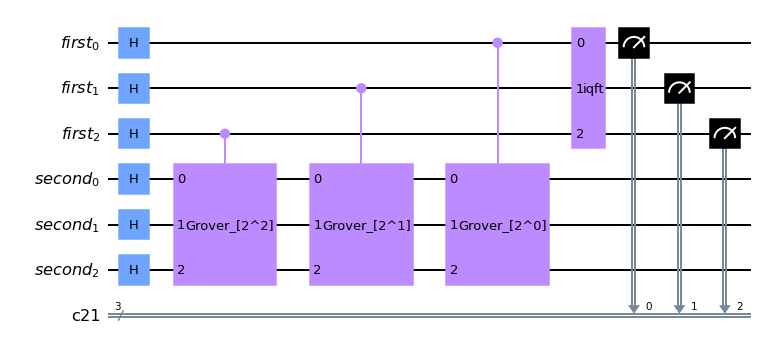

In [175]:
###### solution here

# and a contolled version of the Grover iterator
def cGrover(k):
    
    # make gate for 2^k repetitions of grover
    qc = QuantumCircuit(m)
    for _ in range(2**k):
        qc.append(Grover, range(m))
    grover_k = qc.to_gate()
    grover_k.name = 'Grover_[2^'+str(k)+']'
    
    # make and return controlled version of this gate
    cGrover_k = grover_k.control()
    return cGrover_k   

# number of bits required for the answer
t = 3

# we'll need the inverse QFT
from qiskit.circuit.library import QFT
qft = QFT(t)
inv_qft = qft.inverse()


# the first and second quantum registers, as in the lecture
first = QuantumRegister(t,'first')
second = QuantumRegister(m,'second')

# output for the second register
output = ClassicalRegister(t)

# now make the circuit
circ = QuantumCircuit(first, second, output)

# the first register is initialized as the all |+> state
circ.h(first)

# we'll prepare the |s> state for the qubits of the second register
circ.h(second)

# apply the controlled Grover ops
for k in range(t):    
    circ.append(cGrover(t-k-1), [first[t-k-1]]+[q for q in second] )
            
# do an inverse qft
circ.append(inv_qft, first)
        
# measure
circ.measure(first, output)
    

###################    
circ.draw('mpl')

<h4 style="font-size: 17px">&#128211;Step C. Execute the circuit that you built in Step B and find the number of solutions, $M$, from the estimated phase. </h4>

In [172]:
sim = Aer.get_backend('qasm_simulator')
shots = 20000

Results with bit strings {'10001': 19, '00000': 24, '11111': 31, '01011': 54, '10011': 31, '01110': 18, '00010': 46, '10010': 18, '01111': 19, '11100': 107, '01101': 24, '10111': 116, '01010': 66, '10101': 47, '00101': 215, '01001': 125, '11011': 207, '01100': 25, '00100': 97, '10110': 77, '11101': 47, '00110': 1241, '01000': 381, '11000': 385, '10000': 17, '11001': 7580, '11010': 1236, '00001': 39, '00011': 54, '11110': 36, '10100': 25, '00111': 7593}

Results with phases {'0.53125': 19, '0.0': 24, '0.96875': 31, '0.34375': 54, '0.59375': 31, '0.4375': 18, '0.0625': 46, '0.5625': 18, '0.46875': 19, '0.875': 107, '0.40625': 24, '0.71875': 116, '0.3125': 66, '0.65625': 47, '0.15625': 215, '0.28125': 125, '0.84375': 207, '0.375': 25, '0.125': 97, '0.6875': 77, '0.90625': 47, '0.1875': 1241, '0.25': 381, '0.75': 385, '0.5': 17, '0.78125': 7580, '0.8125': 1236, '0.03125': 39, '0.09375': 54, '0.9375': 36, '0.625': 25, '0.21875': 7593}


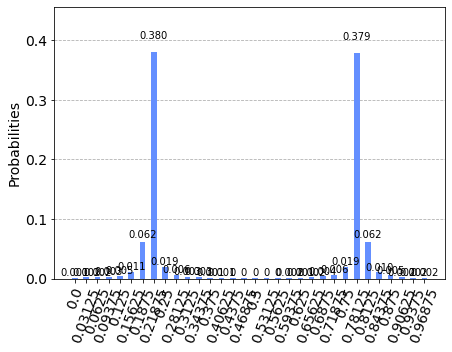

In [173]:
####### solution here
count_circ = execute(circ, sim, shots=shots).result().get_counts()
print('Results with bit strings',count_circ)

def key_convert(count):
    phi_est = np.array([round(int(key, 2)/2**t, t) for key in list(count.keys())])
    key_new = list(map(str, phi_est))
    count_new = dict(zip(key_new, count.values()))
    return count_new

count_new = key_convert(count_circ)
print('\nResults with phases',count_new)

plot_histogram(count_new)

To convert from this phase to an angle, we need to multiple it by $\pi$. Also we need to recall that the angle is defined as $\sqrt{\frac{M}{N}} = \cos(\theta)$. So the number of solution, $M$, is

$$ M = N \cos(\pi \phi).$$

In [183]:
errors = 0

for phi in count_new:
    
    theta = float(phi)*np.pi
    
    if count_new[phi]>shots/10: # ignore spurious solutions

        M = np.rint(N * np.sin(theta)**2)
    
        print('Phase',phi,'implies',M,'solutions for the given oracle.')
        
    else:
        errors += count_new[phi]
        
print('\nSpurious solutions occurred for',errors,'out of',shots,'shots.')

Phase 0.78125 implies 3.0 solutions for the given oracle.
Phase 0.21875 implies 3.0 solutions for the given oracle.

Spurious solutions occurred for 4827 out of 20000 shots.
